In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

In [82]:
sns.set_style('whitegrid')
# sns.set(context="paper", font="monospace")

## Data Loading 

In [83]:
def load_training_dataset():
    return pd.read_csv('data/train_LZdllcl.csv', index_col='employee_id')
df = load_training_dataset()
df = df.rename(columns={'KPIs_met >80%':'is_kpi_met', 'awards_won?':'has_won_awards'})
print('Train Data Size :', df.shape)
df.head()

Train Data Size : (54808, 13)


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [84]:
test = pd.read_csv('data/test_2umaH9m.csv', index_col='employee_id')
test = test.rename(columns={'KPIs_met >80%':'is_kpi_met', 'awards_won?':'has_won_awards'})
print('Test Data Size :', test.shape)
test.head()

Test Data Size : (23490, 12)


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score
employee_id,,,,,,,,,,,,
8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [85]:
test.isnull().sum()

department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
is_kpi_met                 0
has_won_awards             0
avg_training_score         0
dtype: int64

## Data Pre-processing 

In [86]:
df.isnull().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
is_kpi_met                 0
has_won_awards             0
avg_training_score         0
is_promoted                0
dtype: int64

In [87]:
print(df.info())

df['is_promoted'] = df['is_promoted'].astype(np.int8)
df['avg_training_score'] = df['avg_training_score'].astype(np.int8)
df['has_won_awards'] = df['has_won_awards'].astype(np.int8)
df['is_kpi_met'] = df['is_kpi_met'].astype(np.int8)
df['length_of_service'] = df['length_of_service'].astype(np.int8)
df['age'] = df['age'].astype(np.int8)
df['no_of_trainings'] = df['no_of_trainings'].astype(np.int8)

df['previous_year_rating'] = df['previous_year_rating'].astype(np.float16)

df['department'] = df['department'].astype('category')
df['region'] = df['region'].astype('category')
df['education'] = df['education'].astype('category')
df['gender'] = df['gender'].astype('category')
df['recruitment_channel'] = df['recruitment_channel'].astype('category')

print('\nAfter processing:\n',)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54808 entries, 65438 to 51526
Data columns (total 13 columns):
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
is_kpi_met              54808 non-null int64
has_won_awards          54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 5.9+ MB
None

After processing:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54808 entries, 65438 to 51526
Data columns (total 13 columns):
department              54808 non-null category
region                  54808 non-null category

In [88]:
print(test.info())

# test['is_promoted'] = test['is_promoted'].astype(np.int8)
test['avg_training_score'] = test['avg_training_score'].astype(np.int8)
test['has_won_awards'] = test['has_won_awards'].astype(np.int8)
test['is_kpi_met'] = test['is_kpi_met'].astype(np.int8)
test['length_of_service'] = test['length_of_service'].astype(np.int8)
test['age'] = test['age'].astype(np.int8)
test['no_of_trainings'] = test['no_of_trainings'].astype(np.int8)

test['previous_year_rating'] = test['previous_year_rating'].astype(np.float16)

test['department'] = test['department'].astype('category')
test['region'] = test['region'].astype('category')
test['education'] = test['education'].astype('category')
test['gender'] = test['gender'].astype('category')
test['recruitment_channel'] = test['recruitment_channel'].astype('category')

print('\nAfter processing:\n',)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 8724 to 5973
Data columns (total 12 columns):
department              23490 non-null object
region                  23490 non-null object
education               22456 non-null object
gender                  23490 non-null object
recruitment_channel     23490 non-null object
no_of_trainings         23490 non-null int64
age                     23490 non-null int64
previous_year_rating    21678 non-null float64
length_of_service       23490 non-null int64
is_kpi_met              23490 non-null int64
has_won_awards          23490 non-null int64
avg_training_score      23490 non-null int64
dtypes: float64(1), int64(6), object(5)
memory usage: 2.3+ MB
None

After processing:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 8724 to 5973
Data columns (total 12 columns):
department              23490 non-null category
region                  23490 non-null category
education               22456 non-null category


In [89]:
df_promoted = df[df.is_promoted==1]
df_others = df[df.is_promoted==0].sample(df_promoted.shape[0])
df_sample = pd.concat([df_promoted, df_others])
print('Promoted : ', df_promoted.shape[0], ', Others :', df_others.shape[0], ', Combined Sample :', df_sample.shape[0])
df_sample.corr()

Promoted :  4668 , Others : 4668 , Combined Sample : 9336


,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.086655,-0.064460,-0.055541,-0.040467,-0.023720,0.041828,-0.050727
age,-0.086655,1.000000,0.013980,0.662346,-0.022024,0.001200,-0.043713,-0.013781
previous_year_rating,-0.064460,0.013980,1.000000,-0.007145,0.288451,0.065395,0.118247,0.296021
length_of_service,-0.055541,0.662346,-0.007145,1.000000,-0.051622,-0.058080,-0.035308,-0.010985
is_kpi_met,-0.040467,-0.022024,0.288451,-0.051622,1.000000,0.038217,0.025972,0.369471
has_won_awards,-0.023720,0.001200,0.065395,-0.058080,0.038217,1.000000,0.174044,0.210118
avg_training_score,0.041828,-0.043713,0.118247,-0.035308,0.025972,0.174044,1.000000,0.289719
is_promoted,-0.050727,-0.013781,0.296021,-0.010985,0.369471,0.210118,0.289719,1.000000


count    4668.000000
mean       34.372965
std         7.081449
min        20.000000
25%        29.000000
50%        33.000000
75%        38.000000
max        60.000000
Name: age, dtype: float64

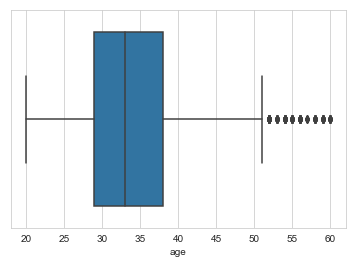

In [90]:
sns.boxplot(x='age', data=df_promoted)
df_promoted.age.describe()

In [91]:
df['is_middle_age'] = df['age'].apply(lambda x: 1 if(x>=29 and x<=38) else 0) #(df['age']>=29 & df['age']<=38)
df['is_middle_age'] = df['is_middle_age'].astype(np.int8)
df['is_middle_age'].unique()
df.corr()

,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score,is_promoted,is_middle_age
no_of_trainings,1.000000,-0.081278,-0.063126,-0.057275,-0.045576,-0.007628,0.042517,-0.024896,0.016499
age,-0.081278,1.000000,0.006008,0.657111,-0.025592,-0.008169,-0.048380,-0.017166,-0.260773
previous_year_rating,-0.063126,0.006008,1.000000,0.000253,0.351578,0.027738,0.075139,0.159320,0.010044
length_of_service,-0.057275,0.657111,0.000253,1.000000,-0.077693,-0.039927,-0.038122,-0.010670,-0.131230
is_kpi_met,-0.045576,-0.025592,0.351578,-0.077693,1.000000,0.097000,0.078391,0.221582,0.028703
has_won_awards,-0.007628,-0.008169,0.027738,-0.039927,0.097000,1.000000,0.072138,0.195871,0.005567
avg_training_score,0.042517,-0.048380,0.075139,-0.038122,0.078391,0.072138,1.000000,0.181147,0.042471
is_promoted,-0.024896,-0.017166,0.159320,-0.010670,0.221582,0.195871,0.181147,1.000000,0.020474
is_middle_age,0.016499,-0.260773,0.010044,-0.131230,0.028703,0.005567,0.042471,0.020474,1.000000


In [92]:
df.education.fillna("Bachelor's", inplace=True)
print(df.education.unique())

def numeric_edu(str):
    if(str.startswith('Master')): return 2
    elif(str.startswith('Bachelor')): return 1
    else: return 0

df['i_education'] = df.education.apply(numeric_edu)
df['i_education'] = df['i_education'].astype(np.int8)
print(df['i_education'].unique())
df.corr()

[Master's & above, Bachelor's, Below Secondary]
Categories (3, object): [Master's & above, Bachelor's, Below Secondary]
[2 1 0]


,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score,is_promoted,is_middle_age,i_education
no_of_trainings,1.000000,-0.081278,-0.063126,-0.057275,-0.045576,-0.007628,0.042517,-0.024896,0.016499,-0.033441
age,-0.081278,1.000000,0.006008,0.657111,-0.025592,-0.008169,-0.048380,-0.017166,-0.260773,0.389036
previous_year_rating,-0.063126,0.006008,1.000000,0.000253,0.351578,0.027738,0.075139,0.159320,0.010044,0.013907
length_of_service,-0.057275,0.657111,0.000253,1.000000,-0.077693,-0.039927,-0.038122,-0.010670,-0.131230,0.266995
is_kpi_met,-0.045576,-0.025592,0.351578,-0.077693,1.000000,0.097000,0.078391,0.221582,0.028703,0.006761
has_won_awards,-0.007628,-0.008169,0.027738,-0.039927,0.097000,1.000000,0.072138,0.195871,0.005567,0.000468
avg_training_score,0.042517,-0.048380,0.075139,-0.038122,0.078391,0.072138,1.000000,0.181147,0.042471,0.025646
is_promoted,-0.024896,-0.017166,0.159320,-0.010670,0.221582,0.195871,0.181147,1.000000,0.020474,0.028026
is_middle_age,0.016499,-0.260773,0.010044,-0.131230,0.028703,0.005567,0.042471,0.020474,1.000000,0.031359
i_education,-0.033441,0.389036,0.013907,0.266995,0.006761,0.000468,0.025646,0.028026,0.031359,1.000000


## Rank Features By Importance

In [93]:
# Find and Remove attributes with low variance
nullList = []
for x in df.select_dtypes(include=[np.number]):
    p=df[x].std()
    if ( p < 0.01 ) :
        nullList.append(x)
# df = df.drop(nullList, axis=1)
nullList

[]

In [94]:
def numerify(ser):
    return LabelEncoder().fit_transform(ser)

df2 = df.copy()

df2['previous_year_rating'] = df2['previous_year_rating'].fillna(3)

# select_categorical_cols = ['department', 'region','education', 'gender', 'recruitment_channel']
df2['department'] = numerify(df2['department'])
df2['region'] = numerify(df2['region'])
df2['education'] = numerify(df2['education'])
df2['gender'] = numerify(df2['gender'])
df2['recruitment_channel'] = numerify(df2['recruitment_channel'])
df2.head().T

employee_id,65438,65141,7513,2542,48945
department,7.0,4.0,7.0,7.0,8.0
region,31.0,14.0,10.0,15.0,18.0
education,2.0,0.0,0.0,0.0,0.0
gender,0.0,1.0,1.0,1.0,1.0
recruitment_channel,2.0,0.0,2.0,0.0,0.0
no_of_trainings,1.0,1.0,1.0,2.0,1.0
age,35.0,30.0,34.0,39.0,45.0
previous_year_rating,5.0,5.0,3.0,1.0,3.0
length_of_service,8.0,4.0,7.0,10.0,2.0
is_kpi_met,1.0,0.0,0.0,0.0,0.0


In [95]:
##Split train data-set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df2[df2.columns.difference(['is_promoted'])], 
                                                    df2['is_promoted'], 
                                                    train_size = 0.75, 
                                                    random_state = 42)

## Find Feature Importances
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)

names = df2.columns.values #select_columns #x_train.columns
scores = map(lambda x: round(x, 4), rf.feature_importances_)
score_map = zip(scores, names)
print("Features sorted by their score:")
# for a,b in sorted(score_map, reverse=True):
for a,b in sorted(score_map, reverse=True):
    print(a,b)

C:\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Features sorted by their score:
0.2933 region
0.1281 department
0.1267 is_middle_age
0.1139 is_kpi_met
0.0943 education
0.0582 avg_training_score
0.0472 previous_year_rating
0.0314 is_promoted
0.0304 no_of_trainings
0.0256 has_won_awards
0.0241 recruitment_channel
0.0129 length_of_service
0.007 gender
0.007 age


In [96]:
# df2.describe().T
# print(df2['previous_year_rating'].value_counts())
# df2['previous_year_rating'].unique()
df2.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score,is_promoted,is_middle_age,i_education
employee_id,,,,,,,,,,,,,,,
65438,7,31,2,0,2,1,35,5.0,8,1,0,49,0,1,2
65141,4,14,0,1,0,1,30,5.0,4,0,0,60,0,1,1
7513,7,10,0,1,2,1,34,3.0,7,0,0,50,0,1,1
2542,7,15,0,1,0,2,39,1.0,10,0,0,50,0,0,1
48945,8,18,0,1,0,1,45,3.0,2,0,0,73,0,0,1


## Data Modeling

In [97]:
class RatingsImputer(BaseEstimator, TransformerMixin):
    def fit (self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        #X.loc[X.previous_year_rating.isnull(), 'previous_year_rating'] = 0
        X = X.fillna({'previous_year_rating':3})
        return X

class EducationCleanser(BaseEstimator, TransformerMixin):
    def fit (self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X = X.fillna({'education':"Bachelor's"})
        return X
    
# fillna_pipe.fit_transform(df).isnull().sum() # For Testing purpose only

In [100]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit (self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.__columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using LabelEncoder(). 
        If no columns specified, transforms all columns in X.
        '''
        output = X.copy()
        if self.__columns is not None:
            for col in self.__columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [101]:
select_numeric_cols = ['avg_training_score', 'has_won_awards', 'is_kpi_met', 'previous_year_rating']
select_categorical_cols = ['department', 'region','education', 'gender', 'recruitment_channel'] # select_categorical_cols = []
select_columns = select_numeric_cols + select_categorical_cols

fillna_pipe = make_pipeline(RatingsImputer(), EducationCleanser())
# fillna_pipe = make_pipeline(RatingsImputer())
select_categorical_cols_pipe = make_pipeline(ColumnSelector(columns=select_categorical_cols), MultiColumnLabelEncoder())
select_numeric_cols_pipe = make_pipeline(ColumnSelector(columns=select_numeric_cols),RobustScaler())

select_fu = make_union(select_numeric_cols_pipe, select_categorical_cols_pipe)
select_pipe = make_pipeline(fillna_pipe, select_fu)

train_vec = select_pipe.fit_transform(df[select_columns])
# test_vec = select_pipe.transform(test[select_columns])
print(train_vec.shape)
print(train_vec[:3])

(54808, 9)
[[-0.44  0.    1.    2.    7.   31.    2.    0.    2.  ]
 [ 0.    0.    0.    2.    4.   14.    0.    1.    0.  ]
 [-0.4   0.    0.    0.    7.   10.    0.    1.    2.  ]]


In [102]:
# Split train data-set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_vec, 
                                                    df['is_promoted'], 
                                                    train_size = 0.75, 
                                                    random_state = 42)

C:\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [103]:
## Find Feature Importances
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)

names = select_columns #x_train.columns
scores = map(lambda x: round(x, 4), rf.feature_importances_)
score_map = zip(scores, names)
print("Features sorted by their score:")
# for a,b in sorted(score_map, reverse=True):
for a,b in sorted(score_map, reverse=True):
    print(a,b)

Features sorted by their score:
0.4268 avg_training_score
0.207 region
0.1293 department
0.0678 previous_year_rating
0.0518 is_kpi_met
0.0348 has_won_awards
0.0346 recruitment_channel
0.0253 gender
0.0227 education


In [104]:
test_vec = select_pipe.transform(test[select_columns])
test_vec[:5]

array([[ 0.68,  0.  ,  1.  ,  0.  ,  8.  , 18.  ,  0.  ,  1.  ,  2.  ],
       [-0.36,  0.  ,  0.  ,  0.  ,  2.  , 28.  ,  0.  ,  0.  ,  0.  ],
       [-0.52,  0.  ,  0.  , -2.  ,  7.  ,  4.  ,  0.  ,  1.  ,  0.  ],
       [ 0.2 ,  0.  ,  0.  , -1.  ,  5.  , 11.  ,  0.  ,  0.  ,  0.  ],
       [ 0.04,  0.  ,  0.  ,  1.  ,  1.  , 21.  ,  0.  ,  1.  ,  2.  ]])

## LGBoost for Classification

In [105]:
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, cross_validate

lgb_clf=LGBMClassifier(random_state=42, silent=False, class_weight={0:1, 1:5}, learning_rate=.05, n_estimators=45)

scores = cross_val_score(lgb_clf, x_train, y_train, cv=3, scoring='f1')
scores

array([0.47920792, 0.49229488, 0.45743429])

In [106]:
from sklearn.metrics import classification_report, confusion_matrix

lgb_clf.fit(x_train, y_train)
preds = lgb_clf.predict(x_test)

print('Accuracy = ', np.mean(preds == y_test))

creport = classification_report(y_test, preds, target_names=['Not Promoted', 'Promoted'])
print(creport)

confusion_matrix(y_test, preds)

Accuracy =  0.9105240110932711
              precision    recall  f1-score   support

Not Promoted       0.96      0.95      0.95     12571
    Promoted       0.46      0.50      0.48      1131

   micro avg       0.91      0.91      0.91     13702
   macro avg       0.71      0.73      0.72     13702
weighted avg       0.91      0.91      0.91     13702



array([[11905,   666],
       [  560,   571]], dtype=int64)

In [ ]:
def conv2df(preds):
    df = pd.DataFrame(data={
        'employee_id': test.index.values,
        'is_promoted': preds
    })
    df['is_promoted'] = df['is_promoted'].astype(np.int8)
    return df

In [ ]:
conv2df(lgb_clf.predict(test_vec)).to_csv('data/output/final_submission.csv', index=False)

In [107]:
from sklearn.preprocessing import CategoricalEncoder